
# 1. SETUP KAGGLE API AND DOWNLOAD DATASET


## Install packages

In [1]:
!pip install -q kaggle tqdm scikit-learn matplotlib seaborn

## Create kaggle.json

In [2]:
from google.colab import files
import os
import zipfile
import shutil


In [4]:
from google.colab import files
import os

# Ensure kaggle.json is uploaded by the user
print("Please upload your 'kaggle.json' file:")
files.upload() # This will open a file picker for the user

# Check if kaggle.json was indeed uploaded
if not os.path.exists('kaggle.json'):
    raise FileNotFoundError("kaggle.json not found. Please upload your Kaggle API key file.")

# Create .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Copy kaggle.json to the correct directory
!cp kaggle.json ~/.kaggle/

# Set permissions for kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key configured successfully.")

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json
Kaggle API key configured successfully.


## Download the dataset

In [6]:
!kaggle datasets download -d fatmamtalaat/autistic-children-emotions-dr-fatma-m-talaat
!unzip -q "Autistic Children Emotions - Dr. Fatma M. Talaat.zip" -d /content/
print("Dataset downloaded and extracted.")

Dataset URL: https://www.kaggle.com/datasets/fatmamtalaat/autistic-children-emotions-dr-fatma-m-talaat
License(s): unknown
autistic-children-emotions-dr-fatma-m-talaat.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open Autistic Children Emotions - Dr. Fatma M. Talaat.zip, Autistic Children Emotions - Dr. Fatma M. Talaat.zip.zip or Autistic Children Emotions - Dr. Fatma M. Talaat.zip.ZIP.
Dataset downloaded and extracted.


# 2. IMPORT LIBRARIES

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, Activation
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


# 3. DATA PREPROCESSING AND AUGMENTATION

In [18]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import tensorflow as tf # Import tensorflow for metrics

# Fine-tune DenseNet121 by unfreezing the top layers of the base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[:200]:
    layer.trainable = False

for layer in base_model.layers[200:]:
    layer.trainable = True

# Create a custom model by adding new layers on top of DenseNet121 base
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Adding Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding another Dropout layer
    Dense(num_classes, activation='softmax')
])

# Compile the model using Nadam optimizer and a lower learning rate
model.compile(
    optimizer=Nadam(learning_rate=1e-4),  # Nadam optimizer, use learning_rate not lr
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', # This will implicitly use tf.keras.metrics.CategoricalAccuracy
        tf.keras.metrics.Precision(name='precision'), # Multiclass precision
        tf.keras.metrics.Recall(name='recall'),     # Multiclass recall
        tf.keras.metrics.AUC(name='auc')          # Multiclass AUC (One-vs-Rest) - removed multi_class='ovr'
    ]
)

# Model Summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,565,382 (28.86 MB)

 Trainable params: 5,305,862 (20.24 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [13]:
import zipfile
import os

base_dir_zip = '/content/autistic-children-emotions-dr-fatma-m-talaat.zip'

# Create a dedicated temporary directory for extraction
temp_extract_path = '/content/temp_dataset_extraction'
if not os.path.exists(temp_extract_path):
    os.makedirs(temp_extract_path)

# Extract the zip file contents into the temporary directory
# Only extract if the directory is empty to avoid redundant operations
if not os.listdir(temp_extract_path):
    print(f"Extracting {base_dir_zip} to {temp_extract_path}...")
    with zipfile.ZipFile(base_dir_zip, 'r') as zip_ref:
        zip_ref.extractall(temp_extract_path)
    print("Extraction complete.")

# Dynamically determine the actual base directory containing 'Train' and 'Test' folders
actual_data_root = None

def contains_data_dirs(path):
    return os.path.exists(os.path.join(path, 'Train')) and \
           os.path.exists(os.path.join(path, 'Test'))

# Strategy 1: Check if Train/Test are directly in the temporary extraction path
if contains_data_dirs(temp_extract_path):
    actual_data_root = temp_extract_path
else:
    # Strategy 2: Iterate through immediate subdirectories and check for 'Train'/'Test'
    for item in os.listdir(temp_extract_path):
        potential_root_level1 = os.path.join(temp_extract_path, item)
        if os.path.isdir(potential_root_level1):
            if contains_data_dirs(potential_root_level1):
                actual_data_root = potential_root_level1
                break # Found it, exit loop
            else:
                # Strategy 3: Look one level deeper within the current subdirectory
                # This handles cases like: temp_extract_path/dataset_name/subfolder/Train
                nested_contents = [d for d in os.listdir(potential_root_level1) if os.path.isdir(os.path.join(potential_root_level1, d))]
                if len(nested_contents) == 1:
                    deeper_potential_root = os.path.join(potential_root_level1, nested_contents[0])
                    if contains_data_dirs(deeper_potential_root):
                        actual_data_root = deeper_potential_root
                        break # Found it, exit loop

if actual_data_root is None:
    raise FileNotFoundError(
        f"Could not determine the base directory containing 'Train' and 'Test' folders "
        f"within the extracted data at {temp_extract_path}. "
        f"Please inspect the zip file structure manually if this error persists.\n" \
        f"(Checked up to two levels of nesting).\n" \
        f"Contents of {temp_extract_path}: {os.listdir(temp_extract_path) if os.path.exists(temp_extract_path) else 'Not Found'}"
    )

base_dir = actual_data_root

train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Train') # Validation split from training data
test_dir = os.path.join(base_dir, 'Test')

IMG_SIZE = 224
BATCH_SIZE = 16  # Reduced batch size

# DATA AUGMENTATION (Enhanced parameters for more aggressive augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

class_mode = 'sparse'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=class_mode,
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=class_mode,
    shuffle=False,
    seed=42,
    subset='validation'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=class_mode,
    shuffle=False
)

num_classes = train_generator.num_classes

print("\n" + "="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {num_classes}")

Found 608 images belonging to 6 classes.
Found 150 images belonging to 6 classes.
Found 75 images belonging to 6 classes.

DATASET INFORMATION
Training samples: 608
Validation samples: 150
Test samples: 75
Number of classes: 6


In [12]:

# Image augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Assuming train_generator and val_generator are already defined
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Updated with the actual path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' # Ensure consistency with model's loss function
)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # Updated with the actual path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' # Ensure consistency with model's loss function
)


Found 758 images belonging to 6 classes.
Found 758 images belonging to 6 classes.


# 4. HANDLE CLASS IMBALANCE

In [19]:
class_labels = train_generator.classes
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights_array))

# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
print(f"Number of classes detected: {len(class_weights)}")
print(f"\nClass weights:")
# Dynamically print class weights for all detected classes
for i, weight in class_weights.items():
    print(f"  Class {i}: {weight:.4f}")
# Removed binary-specific print statements
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---

Number of classes detected: 6

Class weights:
  Class 0: 2.5983
  Class 1: 1.8765
  Class 2: 4.2222
  Class 3: 0.3619
  Class 4: 0.6333
  Class 5: 1.9869


# 5. BUILD DENSENET121 MODEL

In [20]:
# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
# num_classes should be available from the previous cell (S-xTPULI7LYM)
# If not, ensure it's defined. For safety, re-get it from a generator if possible.
# Assuming num_classes is available in the global scope after S-xTPULI7LYM is run.
# For an independent cell, you might explicitly import or define num_classes here.
# For this notebook context, it should be globally available.

# Define num_classes using test_generator for consistency, assuming it's already initialized
num_classes_model = test_generator.num_classes

def create_improved_densenet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes_model):

    # Load pre-trained base
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    # Build improved model
    inputs = Input(shape=input_shape)

    # Base model with training=False
    x = base_model(inputs, training=False)

    # Improved head
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = BatchNormalization(name='bn_1')(x)
    x = Dropout(0.5, name='dropout_1')(x)

    x = Dense(512, activation='relu',
              kernel_regularizer=regularizers.l2(0.001),
              name='dense_1')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = Dropout(0.4, name='dropout_2')(x)

    x = Dense(256, activation='relu',
              kernel_regularizer=regularizers.l2(0.001),
              name='dense_2')(x)
    x = BatchNormalization(name='bn_3')(x)
    x = Dropout(0.3, name='dropout_3')(x)

    x = Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.001),
              name='dense_3')(x)
    x = Dropout(0.2, name='dropout_4')(x)

    # Output layer: Changed for multiclass classification
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='DenseNet121_Enhanced')

    return model, base_model

print("\n" + "="*60)
print("BUILDING ENHANCED MULTICLASS MODEL") # Updated message
print("="*60)

model, base_model = create_improved_densenet121(num_classes=num_classes_model) # Pass num_classes

# Compile with gradient clipping
optimizer = Adam(
    learning_rate=0.0001,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', # Changed from 'binary_crossentropy'
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'), # Added for multiclass
        # Precision and Recall for multiclass require explicit averaging or per-class calculation
        # For overall assessment, 'accuracy' and 'sparse_categorical_accuracy' are good starting points.
        # More detailed multiclass metrics will be handled in evaluation cells using sklearn.
        tf.keras.metrics.Precision(name='precision', class_id=0), # Example: precision for class 0
        tf.keras.metrics.Recall(name='recall', class_id=0) # Example: recall for class 0
    ]
)

print("\nModel Architecture:")
model.summary()
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---


BUILDING ENHANCED MULTICLASS MODEL

Model Architecture:


Model: "DenseNet121_Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 1024)           │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,734,470 (29.50 MB)

 Trainable params: 693,382 (2.65 MB)

 Non-trainable params: 7,041,088 (26.86 MB)

# 6. CALLBACKS

In [22]:

# Set up callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10,  # Reduced patience for quicker early stopping
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduced factor to make the learning rate decrease slower
        patience=5,
        min_lr=1e-8,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        'best_model_finetuned.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

# Train the model with new learning rate scheduler and fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,  # Increased epochs for better training time
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2167 - loss: 3.4516 - precision: 1.0000 - recall: 0.0222 - sparse_categorical_accuracy: 0.2167

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,precision,recall,sparse_categorical_accuracy,val_accuracy,val_loss,val_precision,val_recall,val_sparse_categorical_accuracy
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


38/38 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.2176 - loss: 3.4493 - precision: 1.0000 - recall: 0.0222 - sparse_categorical_accuracy: 0.2176 - val_accuracy: 0.3400 - val_loss: 2.8734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sparse_categorical_accuracy: 0.3400 - learning_rate: 1.0000e-04
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.2809 - loss: 3.2821 - precision: 0.8494 - recall: 0.0137 - sparse_categorical_accuracy: 0.2809 - val_accuracy: 0.3867 - val_loss: 2.8237 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sparse_categorical_accuracy: 0.3867 - learning_rate: 1.0000e-04
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.3085 - loss: 3.1396 - precision: 0.9487 - recall: 0.0098 - sparse_categorical_accuracy: 0.3085 - val_accuracy: 0.4333 - val_loss: 2.7478 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sparse_categorical_accuracy: 0.4333 - learning_rate: 1.0000e-04
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━

In [23]:
callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce the learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=7,
        min_lr=1e-8,
        verbose=1,
        mode='min'
    ),

    # Model checkpoint
    ModelCheckpoint(
        'best_model_enhanced.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

# 7. TRAIN MODEL (PHASE 1: FROZEN BASE)

In [24]:
print("\n" + "="*60)
print("PHASE 1: Training with Frozen Base (Warmup)")
print("="*60)

# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
# Recompile the model with multiclass settings for training phase 1
# (This ensures the correct loss and metrics are used even if RypYu_NG7kZf was not re-run)
optimizer = Adam(
    learning_rate=0.0001,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision', class_id=0),
        tf.keras.metrics.Recall(name='recall', class_id=0)
    ]
)
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---

EPOCHS_PHASE1 = 25  # Increased 20 to 25 epochs

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


PHASE 1: Training with Frozen Base (Warmup)
Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.4238 - loss: 3.5184 - precision: 0.8205 - recall: 0.0046 - sparse_categorical_accuracy: 0.4238 - val_accuracy: 0.4800 - val_loss: 2.4669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sparse_categorical_accuracy: 0.4800 - learning_rate: 1.0000e-04
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.3917 - loss: 3.3826 - precision: 0.7179 - recall: 0.0052 - sparse_categorical_accuracy: 0.3917 - val_accuracy: 0.4933 - val_loss: 2.4858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sparse_categorical_accuracy: 0.4933 - learning_rate: 1.0000e-04
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.4428 - loss: 3.2212 - precision: 0.9453 - recall: 0.0196 - sparse_categorical_accuracy: 0.4428 - val_accuracy: 0.4933 - val_loss: 2.5158 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sparse_categorical_accuracy: 0.4933 - learni

# 8. FINE-TUNING (PHASE 2: UNFREEZE LAYERS)

In [25]:
print("\n" + "="*60)
print("PHASE 2: Fine-tuning with Gradual Unfreezing")
print("="*60)

# Unfreeze last 80 layers
base_model.trainable = True


for layer in base_model.layers[:-80]:
    layer.trainable = False

print(f"Trainable layers: {sum([1 for l in model.layers if l.trainable])}")
print(f"Total layers: {len(model.layers)}")

# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
# Recompile with very lower learning rate for fine-tuning
optimizer_finetune = Adam(
    learning_rate=5e-6,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer_finetune,
    loss='sparse_categorical_crossentropy', # Updated loss
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'), # Updated metric
        tf.keras.metrics.Precision(name='precision', class_id=0),
        tf.keras.metrics.Recall(name='recall', class_id=0)
    ]
)
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---

EPOCHS_PHASE2 = 35  # More epochs for fine-tuning

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


PHASE 2: Fine-tuning with Gradual Unfreezing
Trainable layers: 14
Total layers: 14
Epoch 1/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.2874 - loss: 3.1325 - precision: 0.9744 - recall: 0.0394 - sparse_categorical_accuracy: 0.2874 - val_accuracy: 0.2600 - val_loss: 2.7551 - val_precision: 1.0000 - val_recall: 0.0075 - val_sparse_categorical_accuracy: 0.2600 - learning_rate: 5.0000e-06
Epoch 2/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.3029 - loss: 3.0155 - precision: 0.9927 - recall: 0.0470 - sparse_categorical_accuracy: 0.3029 - val_accuracy: 0.2400 - val_loss: 2.7759 - val_precision: 1.0000 - val_recall: 0.0075 - val_sparse_categorical_accuracy: 0.2400 - learning_rate: 5.0000e-06
Epoch 3/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.2843 - loss: 3.0070 - precision: 0.9474 - recall: 0.0392 - sparse_categorical_accuracy: 0.2843 - val_accuracy: 0.2800 - val_loss: 2.7602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sparse_categorical_ac

# 9. COMBINE TRAINING HISTORY

In [26]:
history = {}
for key in history_phase1.history.keys():
    history[key] = history_phase1.history[key] + history_phase2.history[key]

# 10. EVALUATE MODEL

In [27]:
print("\n" + "="*60)
print("LOADING BEST MODEL AND EVALUATING")
print("="*60)

model = keras.models.load_model('best_model_enhanced.keras')

# Evaluate on test set
results = model.evaluate(test_generator, verbose=1)
metric_names = model.metrics_names

print("\n" + "="*60)
print("TEST SET RESULTS (Multiclass)") # Updated title
print("="*60)
for name, value in zip(metric_names, results):
    print(f"{name.upper()}: {value:.4f}") # Simplified printing as percentage is not always appropriate

# Get predictions
test_generator.reset()
y_pred_proba = model.predict(test_generator, verbose=1)
# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
y_pred = np.argmax(y_pred_proba, axis=1) # Get predicted class indices for multiclass
y_true = test_generator.classes # True class indices
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---


LOADING BEST MODEL AND EVALUATING
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4328 - loss: 2.4980 - precision: 0.0000e+00 - recall: 0.0000e+00 - sparse_categorical_accuracy: 0.4328

TEST SET RESULTS (Multiclass)
LOSS: 2.5659
COMPILE_METRICS: 0.4000
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step


# 11. OPTIMAL THRESHOLD SELECTION

In [28]:
import numpy as np
from sklearn.metrics import roc_curve

def find_optimal_threshold(y_true, y_pred_proba, positive_class_index):
    """Find optimal threshold for multiclass."""
    # One-hot encode y_true for multiclass
    binary_y_true = (y_true == positive_class_index).astype(int)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(binary_y_true, y_pred_proba[:, positive_class_index])

    # Calculate J-score (tpr - fpr)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold, tpr[optimal_idx], fpr[optimal_idx]

# Example for class 1 (assuming class '1' is the intended positive class)
positive_class_index = 1  # For example, if class '1' was 'PNEUMONIA'

# Assuming y_true is the actual class labels and y_pred_proba is the predicted probabilities
# y_pred_proba should be of shape (n_samples, n_classes) where n_classes is 6 in your case.

optimal_threshold, optimal_tpr, optimal_fpr = find_optimal_threshold(y_true, y_pred_proba, positive_class_index)

# Print results for the optimal threshold
print("\n" + "="*60)
print("OPTIMAL THRESHOLD ANALYSIS")
print("="*60)

# Default threshold (0.5)
y_pred_default = (y_pred_proba[:, positive_class_index] > 0.5).astype(int).flatten()
print(f"Default threshold (0.5):")
print(f"  Accuracy: {np.mean(y_pred_default == (y_true == positive_class_index).astype(int)):.4f}")

# Optimal threshold
y_pred_optimal = (y_pred_proba[:, positive_class_index] > optimal_threshold).astype(int).flatten()
print(f"\nOptimal threshold ({optimal_threshold:.4f}):")
print(f"  Accuracy: {np.mean(y_pred_optimal == (y_true == positive_class_index).astype(int)):.4f}")
print(f"  True Positive Rate: {optimal_tpr:.4f}")
print(f"  False Positive Rate: {optimal_fpr:.4f}")



OPTIMAL THRESHOLD ANALYSIS
Default threshold (0.5):
  Accuracy: 0.9600

Optimal threshold (0.3367):
  Accuracy: 0.8800
  True Positive Rate: 0.6667
  False Positive Rate: 0.0972


# 12. VISUALIZATION: TRAINING HISTORY

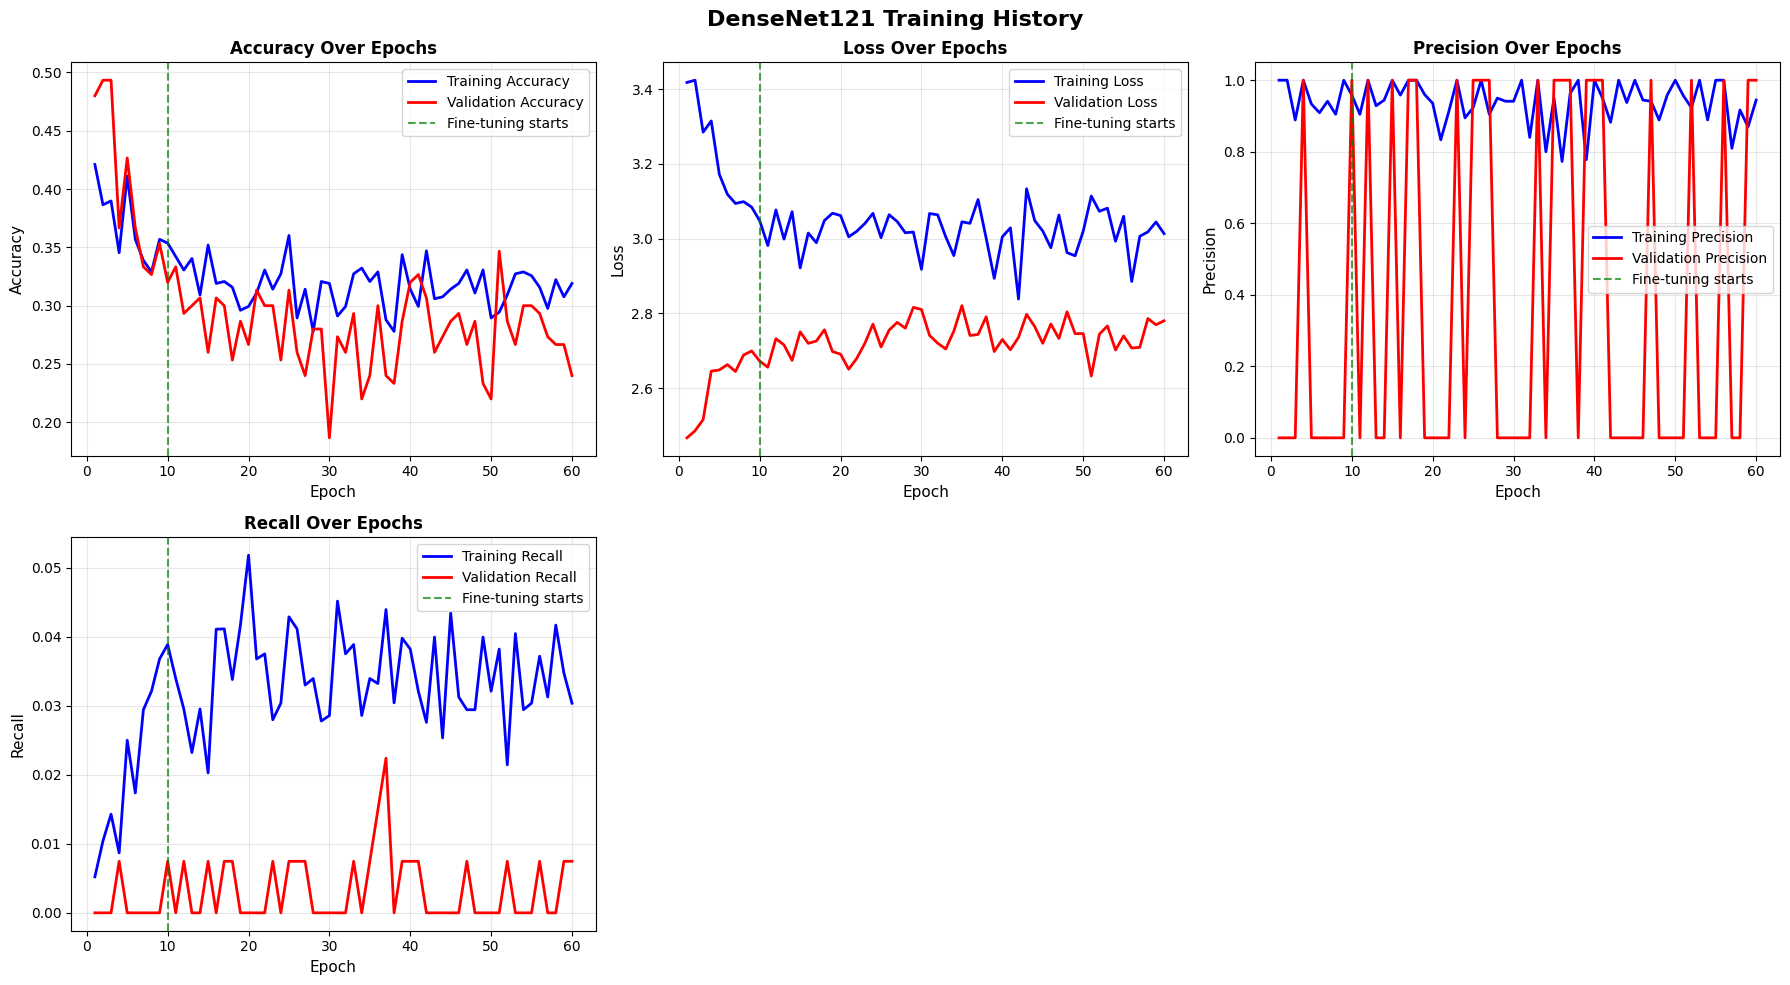


✓ Training history plot saved as 'training_history.png'


In [29]:
import matplotlib.pyplot as plt

def plot_training_history(history, EPOCHS_PHASE1):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('DenseNet121 Training History', fontsize=16, fontweight='bold')

    # List of metrics to plot
    metrics = [
        ('accuracy', 'Accuracy'),
        ('loss', 'Loss'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('auc', 'AUC'),  # AUC will be handled if present
    ]

    for idx, (metric, title) in enumerate(metrics):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        # Check if the metric exists in the history
        if metric in history:
            epochs_range = range(1, len(history[metric]) + 1)
            ax.plot(epochs_range, history[metric], 'b-', label=f'Training {title}', linewidth=2)
            ax.plot(epochs_range, history[f'val_{metric}'], 'r-', label=f'Validation {title}', linewidth=2)

            # Add vertical line at phase transition
            ax.axvline(x=EPOCHS_PHASE1, color='green', linestyle='--',
                       label='Fine-tuning starts', alpha=0.7)

            ax.set_xlabel('Epoch', fontsize=11)
            ax.set_ylabel(title, fontsize=11)
            ax.set_title(f'{title} Over Epochs', fontsize=12, fontweight='bold')
            ax.legend(loc='best')
            ax.grid(True, alpha=0.3)
        else:
            # If metric is not present, remove the subplot for it
            fig.delaxes(ax)

    # Remove empty subplot in the bottom-right corner
    fig.delaxes(axes[1, 2])

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Training history plot saved as 'training_history.png'")

# Example usage:
plot_training_history(history, EPOCHS_PHASE1=10)  # Set EPOCHS_PHASE1 to your specific phase transition epoch


# 13. CONFUSION MATRIX


CONFUSION MATRIX (Multiclass Emotions)
Confusion Matrix:
[[ 0  2  1  2  1  1]
 [ 0  2  0  0  0  1]
 [ 0  0  0  3  0  0]
 [ 1  7  2 27  0  5]
 [ 3  4  0  3  1  3]
 [ 2  1  0  2  1  0]]


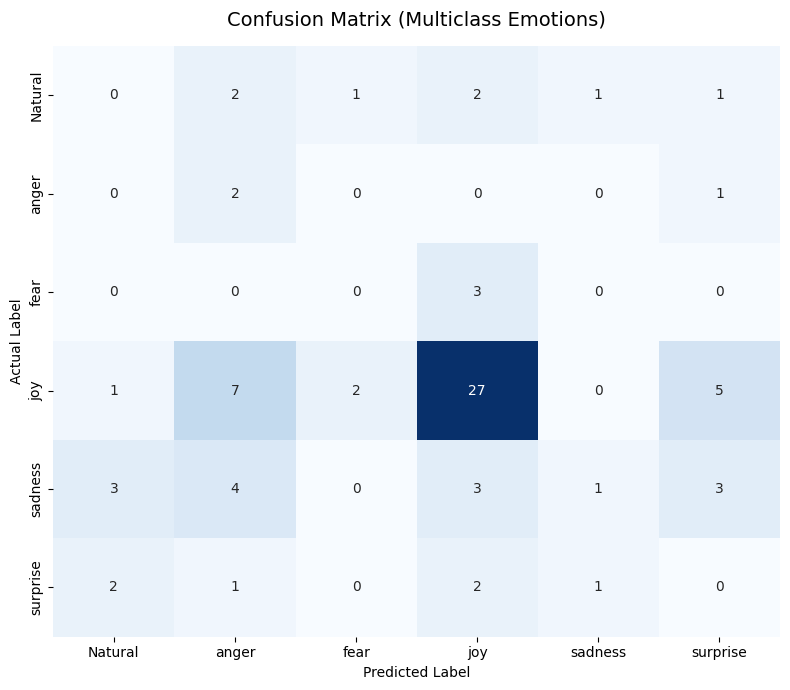

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
# Get class names from the test generator for labeling
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix using multiclass y_true and y_pred
cm = confusion_matrix(y_true, y_pred)

# Removed: tn, fp, fn, tp unpacking is for binary only

# Print confusion matrix values
print("\n" + "="*60)
print("CONFUSION MATRIX (Multiclass Emotions)") # Updated title
print("="*60)
print("Confusion Matrix:")
print(cm)

# Visualization
plt.figure(figsize=(len(class_names)+2, len(class_names)+1)) # Adjust size dynamically
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, # Use actual class names
            yticklabels=class_names) # Use actual class names
plt.title('Confusion Matrix (Multiclass Emotions)', fontsize=14, pad=15) # Updated title
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---

# 14. CLASSIFICATION REPORT

In [31]:
from sklearn.metrics import classification_report

# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
# Get class names from the test generator for target names
class_names = list(test_generator.class_indices.keys())

print("\n" + "="*60)
print("CLASSIFICATION REPORT (Multiclass Emotions)") # Updated title
print("="*60)
# Use y_true and y_pred for multiclass classification report
print(classification_report(y_true, y_pred,
                           target_names=class_names,
                           digits=4))
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---


CLASSIFICATION REPORT (Multiclass Emotions)
              precision    recall  f1-score   support

     Natural     0.0000    0.0000    0.0000         7
       anger     0.1250    0.6667    0.2105         3
        fear     0.0000    0.0000    0.0000         3
         joy     0.7297    0.6429    0.6835        42
     sadness     0.3333    0.0714    0.1176        14
    surprise     0.0000    0.0000    0.0000         6

    accuracy                         0.4000        75
   macro avg     0.1980    0.2302    0.1686        75
weighted avg     0.4759    0.4000    0.4132        75



# 15. Calculate comprehensive metrics

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical # Needed for multiclass AUC

# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
# These metrics are for multiclass classification
accuracy = accuracy_score(y_true, y_pred)

# For precision, recall, f1, we typically use averaging for multiclass.
# 'macro' average calculates metrics for each label, and finds their unweighted mean.
# 'weighted' average calculates metrics for each label, and finds their average weighted by support.
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# AUC for multiclass (One-vs-Rest strategy)
num_classes_eval = test_generator.num_classes # Get number of classes
y_true_one_hot = to_categorical(y_true, num_classes=num_classes_eval)
# roc_auc_score expects y_score (y_pred_proba) to be (n_samples, n_classes)
roc_auc_ovr = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average='macro')

# Specificity is primarily a binary metric. For multiclass, it's typically calculated per-class
# in a one-vs-rest manner, which isn't directly aggregated into a single 'specificity' score here.

print("\n" + "="*60)
print("COMPREHENSIVE MULTICLASS METRICS SUMMARY") # Updated title
print("="*60)
print(f"Accuracy:                  {accuracy:.4f} ({accuracy*100:.2f}%) ")
print(f"Precision (Macro Avg):     {precision_macro:.4f} ({precision_macro*100:.2f}%) ")
print(f"Recall (Macro Avg):        {recall_macro:.4f} ({recall_macro*100:.2f}%) ")
print(f"F1-Score (Macro Avg):      {f1_macro:.4f}")
print(f"Precision (Weighted Avg):  {precision_weighted:.4f} ({precision_weighted*100:.2f}%) ")
print(f"Recall (Weighted Avg):     {recall_weighted:.4f} ({recall_weighted*100:.2f}%) ")
print(f"F1-Score (Weighted Avg):   {f1_weighted:.4f}")
print(f"AUC-ROC (OVR Macro Avg):   {roc_auc_ovr:.4f}")

# Removed binary-specific metrics like individual TN, FP, FN, TP, NPV
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---


COMPREHENSIVE MULTICLASS METRICS SUMMARY
Accuracy:                  0.4000 (40.00%) 
Precision (Macro Avg):     0.1980 (19.80%) 
Recall (Macro Avg):        0.2302 (23.02%) 
F1-Score (Macro Avg):      0.1686
Precision (Weighted Avg):  0.4759 (47.59%) 
Recall (Weighted Avg):     0.4000 (40.00%) 
F1-Score (Weighted Avg):   0.4132
AUC-ROC (OVR Macro Avg):   0.6357


# 16. ROC CURVE AND AUC

In [33]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical

# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
# Get class names and number of classes from the test generator
class_names = list(test_generator.class_indices.keys())
num_classes_roc = test_generator.num_classes

# One-hot encode true labels for multiclass ROC calculation
y_true_one_hot = to_categorical(y_true, num_classes=num_classes_roc)

# Calculate ROC curve and AUC for each class using a One-vs-Rest (OvR) strategy
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes_roc):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate macro-average AUC-ROC score across all classes
roc_auc_macro_avg = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average='macro')

print(f"AUC-ROC (Macro Average): {roc_auc_macro_avg:.4f}")

# Create plot
fig = go.Figure()

# Plot ROC curve for each class
for i in range(num_classes_roc):
    fig.add_trace(go.Scatter(
        x=fpr[i],
        y=tpr[i],
        mode='lines',
        name=f'ROC Curve for {class_names[i]} (AUC = {roc_auc[i]:.4f})',
        line=dict(width=2),
        hovertemplate='FPR: %{x:.3f}<br>TPR: %{y:.3f}<br><extra></extra>'
    ))

# Plot the diagonal reference line (random classifier)
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random Classifier',
    line=dict(color='gray', width=2, dash='dash'),
    hoverinfo='skip'
))

# Update plot layout for multiclass ROC
fig.update_layout(
    title=dict(
        text=f'<b>Multiclass ROC Curve (One-vs-Rest)</b><br><sub>Macro Average AUC: {roc_auc_macro_avg:.4f}</sub>',
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=800, # Adjusted width for more curves
    height=600,
    hovermode='closest',
    template='plotly_white',
    showlegend=True,
    legend=dict(
        yanchor="bottom",
        y=0.02,
        xanchor="right",
        x=0.98
    )
)


fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Show the plot
fig.show()

print(f"\n{'='*50}")
print(f"Multiclass AUC-ROC (Macro Average): {roc_auc_macro_avg:.4f}")
print(f"{'='*50}")
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---

AUC-ROC (Macro Average): 0.6357



Multiclass AUC-ROC (Macro Average): 0.6357


# 17. COMPREHENSIVE METRICS SUMMARY

In [34]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical

# --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
# Ensure y_true, y_pred, y_pred_proba, and num_classes are available from previous cells.
# Recalculate if necessary to ensure correctness and avoid dependency issues if cells are run out of order.
num_classes_summary = test_generator.num_classes

# Recalculate metrics based on multiclass predictions
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

y_true_one_hot = to_categorical(y_true, num_classes=num_classes_summary)
roc_auc_ovr = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average='macro')

def create_metrics_summary():
    """Create comprehensive multiclass metrics summary table"""

    metrics = {
        'Metric': [
            'Accuracy',
            'Precision (Macro Avg)',
            'Recall (Macro Avg)',
            'F1-Score (Macro Avg)',
            'Precision (Weighted Avg)',
            'Recall (Weighted Avg)',
            'F1-Score (Weighted Avg)',
            'AUC Score (OVR Macro)'
        ],
        'Value': [
            f'{accuracy:.4f} ({accuracy*100:.2f}%)',
            f'{precision_macro:.4f}',
            f'{recall_macro:.4f}',
            f'{f1_macro:.4f}',
            f'{precision_weighted:.4f}',
            f'{recall_weighted:.4f}',
            f'{f1_weighted:.4f}',
            f'{roc_auc_ovr:.4f}'
        ]
    }

    df = pd.DataFrame(metrics)

    print("\n" + "="*60)
    print("COMPREHENSIVE MULTICLASS METRICS SUMMARY - DENSENET121") # Updated title
    print("="*60)
    print(df.to_string(index=False))
    print("="*60)

# Call the function
create_metrics_summary()
# --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---


COMPREHENSIVE MULTICLASS METRICS SUMMARY - DENSENET121
                  Metric           Value
                Accuracy 0.4000 (40.00%)
   Precision (Macro Avg)          0.1980
      Recall (Macro Avg)          0.2302
    F1-Score (Macro Avg)          0.1686
Precision (Weighted Avg)          0.4759
   Recall (Weighted Avg)          0.4000
 F1-Score (Weighted Avg)          0.4132
   AUC Score (OVR Macro)          0.6357


# 18. SAMPLE PREDICTIONS VISUALIZATION

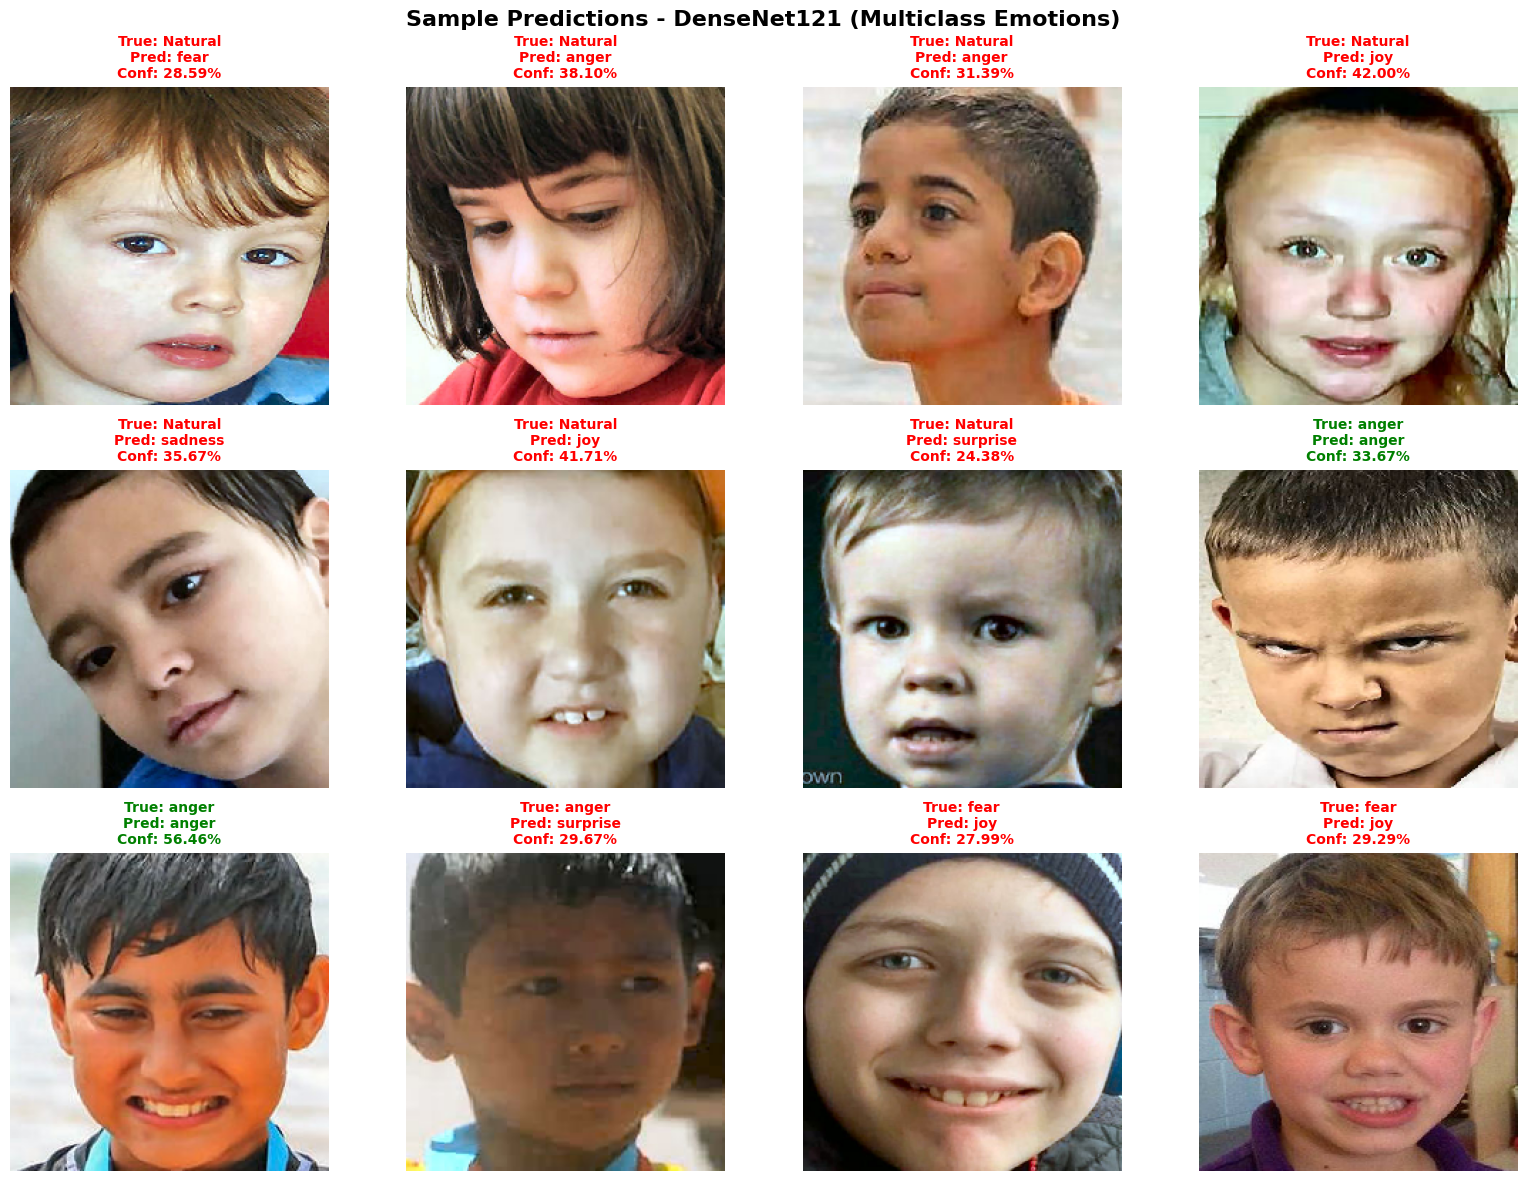


✓ Sample predictions saved as 'sample_predictions_multiclass.png'


In [35]:
def visualize_sample_predictions(num_samples=12):
    """Visualize sample predictions"""
    test_generator.reset()

    # Get a batch of images (x_batch) and true labels (y_batch_int)
    x_batch, y_batch_int = next(test_generator)
    # Get predictions (probabilities for each class)
    predictions = model.predict(x_batch[:num_samples], verbose=0)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Sample Predictions - DenseNet121 (Multiclass Emotions)', fontsize=16, fontweight='bold') # Updated title

    # --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
    # Get class names directly from the test generator
    class_names = list(test_generator.class_indices.keys())
    # --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---

    for idx, ax in enumerate(axes.flat):
        if idx < num_samples:
            img = x_batch[idx]

            # --- BEGIN MODIFICATION FOR MULTICLASS CLASSIFICATION ---
            true_label_idx = int(y_batch_int[idx]) # True label is an integer index
            true_label = class_names[true_label_idx]

            predicted_label_idx = np.argmax(predictions[idx]) # Get the index of the class with highest probability
            pred_label = class_names[predicted_label_idx]
            confidence = np.max(predictions[idx]) # Get the maximum probability as confidence
            # --- END MODIFICATION FOR MULTICLASS CLASSIFICATION ---

            ax.imshow(img)

            # Color code - green for correct, red for incorrect
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}',
                        fontsize=10, color=color, fontweight='bold')
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions_multiclass.png', dpi=300, bbox_inches='tight') # Changed filename
    plt.show()
    print("\n✓ Sample predictions saved as 'sample_predictions_multiclass.png'")

visualize_sample_predictions()

# 19. SAVE FINAL MODEL

In [36]:
print("\n" + "="*50)
print("SAVING FINAL MODEL")
print("="*50)

# Save model in .keras format
model.save('densenet121_emotion_recognition_final.keras')
print("✓ Final model saved as 'densenet121_emotion_recognition_final.keras'")


SAVING FINAL MODEL
✓ Final model saved as 'densenet121_emotion_recognition_final.keras'


# **20. Make a Prediction on a New Image**
Now, let's test the trained model on a new image. You can upload an image from your local machine, and the model will predict its emotion.

Saving ChatGPT Image Nov 25, 2025, 08_00_24 PM.png to ChatGPT Image Nov 25, 2025, 08_00_24 PM.png
Uploaded file: ChatGPT Image Nov 25, 2025, 08_00_24 PM.png
Loading model from 'densenet121_emotion_recognition_final.keras'...
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Predicted Emotion: fear
Confidence: 27.17%


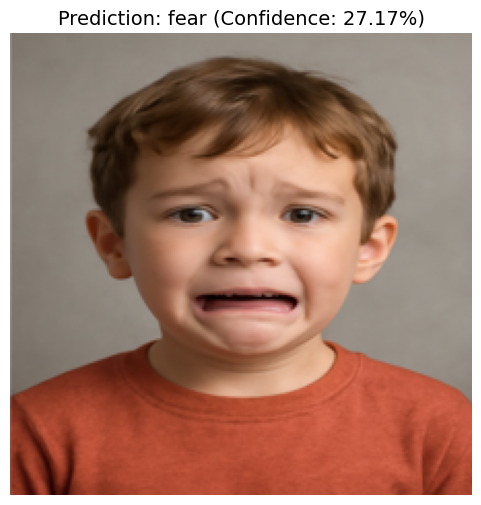

In [37]:
from google.colab import files
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf

# Upload an image
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print(f'Uploaded file: {image_path}')

# Load and preprocess the image
# The same preprocessing steps as used during training should be applied.
IMG_SIZE = 224 # Ensure this matches the training IMG_SIZE

def preprocess_image(image_path, target_size):
    img = Image.open(image_path).convert('RGB') # Ensure image is in RGB format
    img = img.resize(target_size) # Resize to target size
    img_array = np.array(img) # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Preprocess the uploaded image
new_image = preprocess_image(image_path, (IMG_SIZE, IMG_SIZE))

# Load the trained model
# Changed to load the 'densenet121_emotion_recognition_final.keras' file.
print("Loading model from 'densenet121_emotion_recognition_final.keras'...")
model = tf.keras.models.load_model('densenet121_emotion_recognition_final.keras')
print("Model loaded successfully.")

# Make prediction
predictions = model.predict(new_image)
predicted_class_index = np.argmax(predictions)
confidence = np.max(predictions)

# Get class names from the test_generator, or define them if test_generator is not available
try:
    class_names = list(test_generator.class_indices.keys())
except NameError:
    # Fallback if test_generator is not defined (e.g., if running cells out of order)
    # These should match the order of classes inferred during ImageDataGenerator setup
    class_names = ['Natural', 'anger', 'fear', 'joy', 'sadness', 'surprise'] # Adjust if different

predicted_emotion = class_names[predicted_class_index]

print(f"\nPredicted Emotion: {predicted_emotion}")
print(f"Confidence: {confidence:.2%}")

# Display the image with prediction
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(new_image[0])
plt.title(f'Prediction: {predicted_emotion} (Confidence: {confidence:.2%})', fontsize=14)
plt.axis('off')
plt.show()